## Alexnet w/ Stanford Cars Dataset (196 Classes)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization

from tensorflow.keras.optimizers import SGD

In [3]:
train_path = '/content/gdrive/MyDrive/Kaggle_StanfordCars/car_data_49/train'
test_path = '/content/gdrive/MyDrive/Kaggle_StanfordCars/car_data_49/test'

In [4]:
gen_params = {"rescale":1.0/255,
              "featurewise_center":False,
              "samplewise_center":False,
              "featurewise_std_normalization":False,
              "samplewise_std_normalization":False,
              "zca_whitening":False,
              "rotation_range":20,
              "width_shift_range":0.1,
              "height_shift_range":0.1,
              "shear_range":0.2,
              "zoom_range":0.1,
              "horizontal_flip":True,
              "fill_mode":'constant',
              "cval": 0,
              "validation_split":0.25}

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)


## Data generator for training images
train_generator = train_datagen.flow_from_directory(train_path,
                                                    class_mode='categorical', batch_size = 32,
                                                    target_size=(224,224),color_mode='rgb',shuffle = True,subset='training')

val_generator = train_datagen.flow_from_directory(train_path,
                                                    class_mode='categorical', batch_size = 32, 
                                                    target_size=(224,224),color_mode='rgb',shuffle = True,subset='validation')

test_generator = test_datagen.flow_from_directory(test_path,
                                                    class_mode='categorical', batch_size = 32,
                                                    target_size=(224,224),color_mode='rgb',shuffle = True)

Found 9138 images belonging to 49 classes.
Found 3021 images belonging to 49 classes.
Found 4026 images belonging to 49 classes.


<a id='implementation'></a>
# Implementation

In [5]:
model = Sequential(name="Alexnet_StanfordCars")
model.add(Conv2D(filters= 96, kernel_size= (11,11), strides=(4,4), padding='valid', input_shape = (224,224,3)))
model.add(Activation('relu'))  
model.add(MaxPool2D(pool_size=(3,3), strides= (2,2), padding='valid'))
model.add(BatchNormalization())
    
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'))
model.add(BatchNormalization())
            
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
            
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'))

model.add(Flatten())

model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.5))
                           
model.add(Dense(units = 49, activation = 'softmax'))

model.summary()

Model: "Alexnet_StanfordCars"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 25

In [6]:
# set the SGD optimizer with lr of 0.01 and momentum of 0.9
optimizer = SGD(lr = 0.01, momentum = 0.9)

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [7]:
model_name = "alexnet_cars_49.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [8]:
# train the model
batch = 128
num_epochs = 100

history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=num_epochs,
                    verbose=1,
                    batch_size=batch,
                    callbacks=[early_stop,monitor,lr_schedule])

Epoch 1/100
286/286 [==============================] - 10206s 36s/step - loss: 6.1295 - accuracy: 0.0636 - val_loss: 3.5706 - val_accuracy: 0.0771
Epoch 2/100
286/286 [==============================] - 157s 550ms/step - loss: 3.6295 - accuracy: 0.0850 - val_loss: 3.5279 - val_accuracy: 0.1082
Epoch 3/100
286/286 [==============================] - 159s 555ms/step - loss: 3.5552 - accuracy: 0.0922 - val_loss: 3.4732 - val_accuracy: 0.1056
Epoch 4/100
286/286 [==============================] - 160s 558ms/step - loss: 3.5031 - accuracy: 0.0988 - val_loss: 3.4481 - val_accuracy: 0.1096
Epoch 5/100
286/286 [==============================] - 159s 555ms/step - loss: 3.4509 - accuracy: 0.0986 - val_loss: 3.4024 - val_accuracy: 0.1139
Epoch 6/100
286/286 [==============================] - 159s 557ms/step - loss: 3.3712 - accuracy: 0.1050 - val_loss: 3.3710 - val_accuracy: 0.1135
Epoch 7/100
286/286 [==============================] - 159s 558ms/step - loss: 3.3723 - accuracy: 0.1053 - val_loss: 3

<a id='analyze'></a>
# Analyze training history

In [9]:
max(history.history['accuracy'])

0.16447800397872925

In [10]:
max(history.history['val_accuracy'])

0.16352201998233795

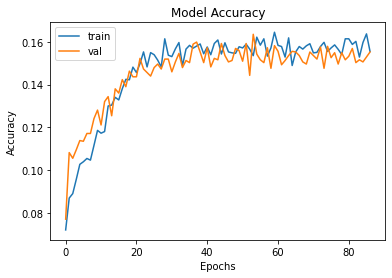

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<a id='prediction'></a>
# Prediction

In [12]:
print(model_name)

alexnet_cars_49.h5


In [13]:
model.load_weights(model_name)
metrics = model.evaluate(test_generator)

126/126 [==============================] - 2785s 22s/step - loss: 3.0954 - accuracy: 0.1547
